# Lab 4: AirBnB data

This week, we look at some airbnb listings. We look at covariance between columns, and practice table merging.

In [1]:
library(dplyr)
library(ggplot2)
load("lab4.Rdata")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


lab4.RData contains two data frames: listing, demo. Let's take a look.
listing basically has all the info you would find on a rental page.

In [2]:
listing %>% glimpse()

Observations: 23,624
Variables: 29
$ accommodates                <dbl> 2, 2, 6, 1, 2, 2, 2, 2, 3, 1, 2, 4, 3, 4,…
$ amenities                   <chr> "{}", "{\"Wireless Internet\",\"Air condi…
$ availability_30             <int> 29, 18, 3, 0, 6, 22, 10, 0, 3, 20, 17, 27…
$ bathrooms                   <dbl> 1.0, 1.0, 1.0, 1.0, 1.0, NA, 1.5, 1.0, 2.…
$ bed_type                    <chr> "Real Bed", "Real Bed", "Real Bed", "Real…
$ bedrooms                    <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ beds                        <dbl> 1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2,…
$ cancellation_policy         <chr> "flexible", "flexible", "flexible", "flex…
$ city                        <chr> "palmdale", "acton", "acton", "los angele…
$ has_availability            <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ host_id                     <int> 44800067, 84615808, 71743973, 41646908, 8…
$ id                          <int> 8909380, 14078522, 13006928, 7898757, 160…
$ instant_bookabl

Some demographic info by zipcode are in demo

In [3]:
demo %>% head()

zipcode,population,median_household_income,mean_household_income
601,17982,10816,20349
602,40260,16079,23282
603,52408,16804,26820
606,6331,12512,15730
610,28328,17475,23360
612,64816,17229,25590


### Goal: 
Airbnb is meant for home sharing, but there are hosts with more than 20 listings. This is more like commercial hotels without regulation than home sharing. We would like to identify such users and see what their impact is on the airbnb ecosystem.

### Step 1:
host_id is a unique identifier for host. id is a unique identifier for listing. Construct a table where for each host_id, we have the number of unique ids, and the mean review_scores_value for that host_id. Call this table tb1. Name the 3 resulting columns host_id, nid, and mean_review.

In [4]:
tb1 <- listing %>% group_by(host_id) %>% 
summarise(nid = length(unique(id)), mean_review = mean(review_scores_value))
tb1[1:20,]

host_id,nid,mean_review
59,1,10.000000
521,1,8.000000
767,1,8.000000
1158,1,10.000000
3041,2,8.500000
3144,1,10.000000
3199,1,10.000000
3405,1,7.000000
3415,5,9.200000
3647,1,10.000000


### Step 2:

Look at a digital clock:
* if the minute is odd, create a sequence of box plots, where the x axis is nid, and y axis is mean_review. 
* if the minute is even, create a scatter plot of mean_review vs nid, add a smooth fitted line.
 
What do you see? If you have made both, what are the things that you can pick off from one plot but not the other?

Warning message:
“Removed 71 rows containing non-finite values (stat_boxplot).”

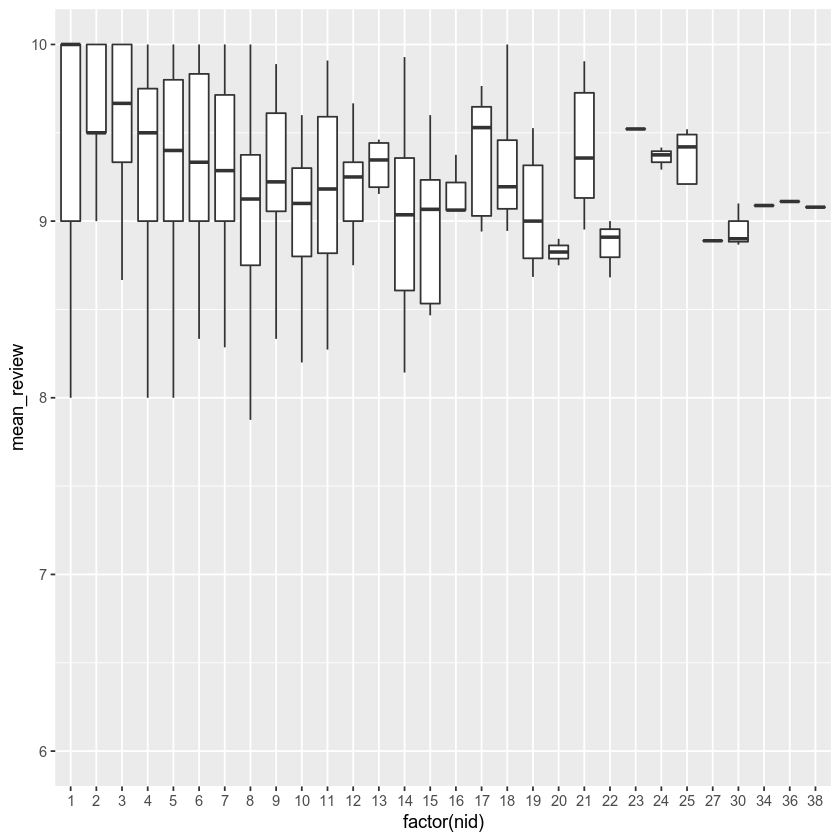

In [5]:
ggplot(data = tb1) + 
    geom_boxplot(mapping = aes(x = factor(nid), y = mean_review), outlier.shape = NA) + ylim(6,10)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


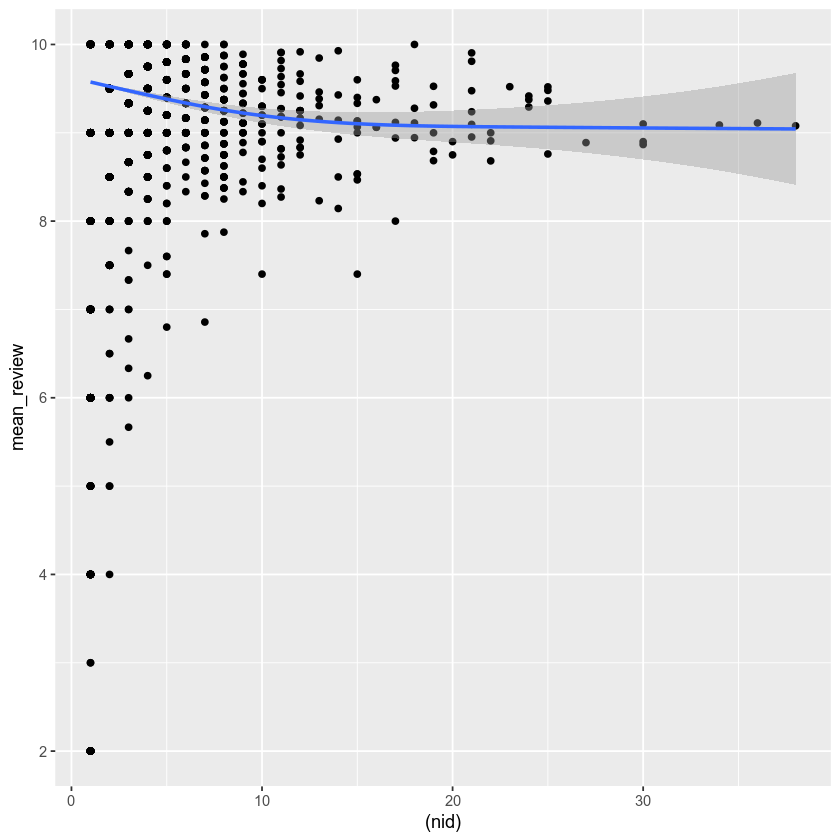

In [6]:
ggplot(data = tb1, mapping = aes(x = (nid), y = mean_review)) + 
    geom_point() + geom_smooth()

### Step 3:
Let's define commercial hosts to be hosts with >= 5 listings. Create a column in listing indicating if this row has a commercial host. (hint: you need to merge tables for this, at least I needed)

In [7]:
tb2 <- tb1 %>% mutate(if_commer = nid >= 5) %>% select(host_id, if_commer)
head(tb2)
listing_new <- listing %>% left_join(tb2)

host_id,if_commer
59,FALSE
521,FALSE
767,FALSE
1158,FALSE
3041,FALSE
3144,FALSE


Joining, by = "host_id"


### Step 4:
In listing, find for each zipcode, the total number of listings, the number of commercial listings (any listing by a commercial host is a commercial listing), and the mean price of all listings; retain only rows with more than 25 listings. Name this table tb3, name four columns zipcode, nlist, ncomlist, and mp.

In [8]:
tb3 <- listing_new %>% group_by(zipcode) %>% 
summarise(nlist = n(), ncomlist = sum(if_commer), mp = mean(price, na.rm = T)) %>%
filter(nlist > 25)
head(tb3)

zipcode,nlist,ncomlist,mp
,249,24,134.32114
90004,290,62,115.34028
90005,195,69,90.78351
90006,279,185,60.90323
90007,113,41,59.18584
90008,46,1,111.21739


### Step 5:
In tb3, add a column of boolean value indicating if this zipcode is "commercial heavy". We define commercial heavy as the number commercial listings exceeding 20% of the total amount of listings. Name the result tb4.

In [9]:
tb4 <- tb3 %>% mutate(com_heavy = (ncomlist/nlist) > 0.2)
tb4 %>% head()

zipcode,nlist,ncomlist,mp,com_heavy
,249,24,134.32114,FALSE
90004,290,62,115.34028,TRUE
90005,195,69,90.78351,TRUE
90006,279,185,60.90323,TRUE
90007,113,41,59.18584,TRUE
90008,46,1,111.21739,FALSE


### Step 6:
Merge in demo info into tb4. Name this table tb5

In [10]:
tb5 <- tb4 %>% left_join(demo)
tb5 %>% head()

Joining, by = "zipcode"


zipcode,nlist,ncomlist,mp,com_heavy,population,median_household_income,mean_household_income
,249,24,134.32114,FALSE,NA,NA,NA
90004,290,62,115.34028,TRUE,64008,40612,72532
90005,195,69,90.78351,TRUE,38979,31142,45224
90006,279,185,60.90323,TRUE,61625,31521,39123
90007,113,41,59.18584,TRUE,43426,22304,33382
90008,46,1,111.21739,FALSE,31837,36564,56076


### Step 7:
Create a scatter plot of mean price vs median household income with tb5. Color points by if this zipcode is commercial heavy. What do you see? What do you learn from this plot?

Warning message:
“Removed 1 rows containing missing values (geom_point).”

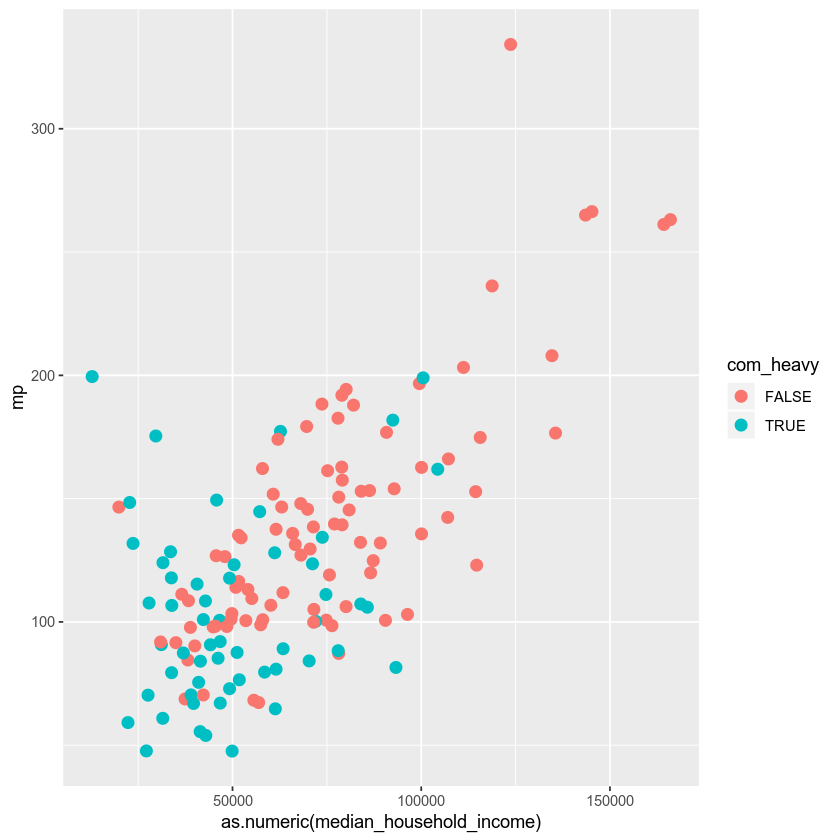

In [11]:
ggplot(data = tb5, 
       mapping = aes(x = as.numeric(median_household_income), 
                     y = mp, color = com_heavy)) + 
    geom_point(size = 3)